# PMAP Cohort
Created: November 3, 2022

1. Create dataframe with Congestive Heart Failure (CHF) related hospital stays w/ ICU and its readmission labels from the Precision Medicine Analytics Platform (PMAP) data.
2. Data Visualization for data quality checks.

Author: Vina Ro

In [191]:
# Import packages
import numpy as np
import pandas as pd
import time as time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

In [192]:
# Set filepath
file_path = Path('PMAP_Init_DF_1103.ipynb').resolve()
data_path = file_path.parent.parent.parent.parent.parent.joinpath('Data/jbergma8/IRB_271579_Faraday/IRB-271579-v3-DEID-220607-no-ptsd')

In [193]:
# Import data
patient      = pd.read_csv(data_path / 'patient.csv')
inpatient    = pd.read_csv(data_path / 'inpatient.csv', parse_dates = ['exp_admission_time','op_adm_date','hosp_admsn_time','hosp_disch_time'])
icustay      = pd.read_csv(data_path / 'icustay.csv', parse_dates = ['in_time','out_time'])
enc_icustay  = pd.read_csv(data_path / 'enc_icustay.csv', parse_dates = ['in_time'])
adt          = pd.read_csv(data_path / 'adt.csv',parse_dates = ['in_time','out_time'])
#adr          = pd.read_csv(data_path / 'an_record_summary.csv')
hosp_billing = pd.read_csv(data_path / 'hosp_billing_dx.csv', usecols = ['osler_sid', 'pat_enc_csn_sid','adm_date_time','icd10_code'])
encounter    = pd.read_csv(data_path / 'encounter_dx.csv')
elixhauser   = pd.read_csv(data_path / 'elixhauser_aqi_pivot.csv', usecols = ['osler_sid','pat_enc_csn_sid','CHF'])
adm          = pd.read_csv(data_path / 'adm-220829.csv', parse_dates = ['adm_dt','dc_dt'])

# Import dictionaries (no patient data)
d_dept_type_v2  = pd.read_csv(data_path / 'dept-type-220506NF.csv')

/home/idies/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Get real hospital stays by verifying billing info and patient whereabouts

In [194]:
# Merge adt with department id and department name
temp = pd.merge(
    adt[['osler_sid', 'pat_enc_csn_sid', 'department_id', 'seq_stay', 'in_time', 'out_time']],
    d_dept_type_v2[['department_id', 'department_name', 'loc', 'ward', 'is_floor', 'is_icu', 'is_or', 'is_ed']], # change based on location desired
    on = 'department_id',
    how = 'left',
    indicator = True)
temp['is_unknown'] = np.where(temp._merge == 'left_only', 1, 0)
temp['is_clinic']  = np.where(temp['loc'] == 'clinic', 1, 0)
temp['is_rads']    = np.where(temp['loc'].isin(['rads', 'rads-op']), 1, 0)
temp['is_study']   = np.where(temp['loc'] == 'study', 1, 0)

# Sum how many times the patient visited each location during encounter
adm_adt = (
    temp.groupby(['osler_sid', 'pat_enc_csn_sid'])
      [['ward', 'is_floor', 'is_icu', 'is_or', 'is_ed', 'is_clinic', 'is_rads', 'is_study', 'is_unknown']]
      .sum())

# Mark 1 if visited floor, icu, and/or ward
adm_adt['adm'] = np.where((adm_adt.is_floor >= 1) | (adm_adt.is_icu >= 1) | (adm_adt.ward >= 1), 1, 0)
adm_adt = adm_adt.dropna()

real_inpatient = (inpatient
                  .merge(adm_adt.query('adm == 1').reset_index(),
                         on = ['osler_sid','pat_enc_csn_sid'],
                         how = 'inner'))
                  
real_inpatient = (real_inpatient
                  .merge(hosp_billing[['osler_sid', 'pat_enc_csn_sid', 'adm_date_time']].drop_duplicates('pat_enc_csn_sid', keep='first'),
                         on=['osler_sid', 'pat_enc_csn_sid'],
                         how='inner'))

real_inpatient.to_csv('real_inpatient.csv',index = False)

In [195]:
real_adm = (adm
            .merge(adm_adt.query('adm == 1').reset_index(),
                         on = ['osler_sid','pat_enc_csn_sid'],
                         how = 'inner'))
                  
real_adm = (real_adm
                  .merge(hosp_billing[['osler_sid', 'pat_enc_csn_sid', 'adm_date_time']].drop_duplicates('pat_enc_csn_sid', keep='first'),
                         on=['osler_sid', 'pat_enc_csn_sid'],
                         how='inner'))
real_adm.to_csv('real_adm.csv',index = False)

### Create DataFrame of hospital stays w/ ICU stays.
Dataframe contains osler_sid, pat_enc_csn_sid, hospital admission time, hospital discharge time, ICU admission time, ICU discharge time.

In [196]:
# Inner merge with enc_icustay to get real enc_csn_sid and initialize dataframe
hosp_icu_stays  = (enc_icustay[['osler_sid','pat_enc_csn_sid','in_time']]
     .merge(
         real_inpatient[['pat_enc_csn_sid', 'hosp_admsn_time', 'hosp_disch_time']],
         on = 'pat_enc_csn_sid',
         how = 'inner')
      .merge(
         icustay[['pat_enc_csn_sid', 'in_time', 'out_time']],
         on = ['pat_enc_csn_sid', 'in_time'],
         how = 'inner'))

# Swap column order for better interpretation in the future
hosp_icu_stays = hosp_icu_stays[['osler_sid', 'pat_enc_csn_sid', 'hosp_admsn_time',
                                       'hosp_disch_time', 'in_time', 'out_time']]

# Keep last icu stay for icu stays with the same pat_enc_csn_sid
hosp_icu_stays = hosp_icu_stays.sort_values(['in_time']).drop_duplicates('pat_enc_csn_sid', keep='last')
hosp_icu_stays = hosp_icu_stays.sort_values('osler_sid').reset_index(drop = True)
hosp_icu_stays.to_csv('unq_idx_icu_stays.csv', index = False)

print('Number of patients that have an index hospital stay w/ an ICU stay: ' + str(hosp_icu_stays.osler_sid.nunique()))
print('Number of index hospital stays w/ ICU stays: ' + str(hosp_icu_stays.pat_enc_csn_sid.nunique()))

Number of patients that have an index hospital stay w/ an ICU stay: 26825
Number of index hospital stays w/ ICU stays: 30375


### Checking if times in ICU is between the time period of hospital admission and discharge

In [197]:
temp = hosp_icu_stays[~((hosp_icu_stays.hosp_admsn_time <= hosp_icu_stays.in_time) & 
                           (hosp_icu_stays.in_time <= hosp_icu_stays.out_time) & 
                           (hosp_icu_stays.out_time <= hosp_icu_stays.hosp_disch_time))].shape[0]
print('Number of wrong datetime entries(adm/disch/inicu/outicu) in unq_idx_icu_stays: ' + str(temp))

Number of wrong datetime entries(adm/disch/inicu/outicu) in unq_idx_icu_stays: 0


### Create a new dataframe with CHF related hospital ICU stays

In [198]:
hosp_billing = hosp_billing.assign(
    CHF = hosp_billing.icd10_code.str.contains(r'I09.9|I11.0|I13.0|I13.2|I25.5|I42.0|I43|I50|P29.0|I42.[5-9]').astype(int)
)

CHF_hosp_billing = hosp_billing[hosp_billing.CHF == 1][['osler_sid','pat_enc_csn_sid','icd10_code']]
CHF = pd.concat([CHF_elix, CHF_hosp_billing], axis = 0)
CHF = CHF.drop_duplicates(['osler_sid','pat_enc_csn_sid']).sort_values(['osler_sid','pat_enc_csn_sid'])

# Because CHF_hosp_billing originally contained duplicates of inpatient stays with multiple CHF billing codes,
# drop duplicates to get unique enc_csns for inpatient stays with CHF ICU stays. 
hosp_sid = CHF_hosp_billing.drop_duplicates(['osler_sid','pat_enc_csn_sid'])['pat_enc_csn_sid']
elix_sid = elixhauser[elixhauser.CHF == 1]['pat_enc_csn_sid']

CHF_enc_csn_sid = set(hosp_sid).intersection(elix_sid)
CHF_hosp_icu_stays = hosp_icu_stays[hosp_icu_stays.pat_enc_csn_sid.isin(CHF_enc_csn_sid)]

# ----- For printing ----- #
hosp_icu_stays = hosp_icu_stays.assign(CHF = hosp_icu_stays.pat_enc_csn_sid.isin(
    CHF_hosp_icu_stays.pat_enc_csn_sid).astype(int))

CHF = hosp_icu_stays[hosp_icu_stays.CHF == 1]
nonCHF = hosp_icu_stays[hosp_icu_stays.CHF == 0]

print('Number of CHF-related hospital stays w/ an ICU stay: ' + str(CHF.shape[0]))
print('Number of patients who have a CHF-related hospital stay w/ an ICU stay: ' + str(CHF.osler_sid.nunique()))
print('Number of non-CHF-related hospital stays w/ an ICU stay: ' + str(nonCHF.shape[0]))
print('Number of patients who have a non-CHF-related hospital stay w/ an ICU stay: ' + str(nonCHF.osler_sid.nunique()))

Number of CHF-related hospital stays w/ an ICU stay: 4488
Number of patients who have a CHF-related hospital stay w/ an ICU stay: 4109
Number of non-CHF-related hospital stays w/ an ICU stay: 25887
Number of patients who have a non-CHF-related hospital stay w/ an ICU stay: 22984


## Creating labels

### Subsetting patients who have a CHF related index icu stay from the adm dataframe

In [199]:
# Filtering adm.csv with patient ids in CHF_hosp_icu_stays
CHF_adm = real_adm[real_adm.osler_sid.isin(CHF_hosp_icu_stays.osler_sid.unique())]

# Marking pat_enc_csn_sids that are the index icu stay from CHF_hosp_icu_stays
CHF_adm = CHF_adm.assign(is_idx_icu = CHF_adm.pat_enc_csn_sid.isin(CHF_hosp_icu_stays.pat_enc_csn_sid).astype(int)) # mark pat_enc_csn_sids that are index icu stays
CHF_adm = CHF_adm[['osler_sid','pat_enc_csn_sid','is_idx_icu','adm_dt','dc_dt','type']].sort_values(['osler_sid','adm_dt']).reset_index(drop = True)

### Generating chronological dataframe by performing shift operations
1. had_readmission_for_icustays: patient has readmission AND the first hospital stay is an ICU stay.
2. time_bt: time btw 2 consecutive admissions in days.
3. had_readmission_for_icustays_1to30: patient has readmission w the first hospital stay being an ICU stay AND time btw 2 consecutive stays is >=1 and <= 30 days.
4. had_readmission_for_icustays_less24: patient has readmission w the first hospital stay being an ICU stay AND time btw 2 consecutive stays is < 1 day.

In [200]:
# Remove all hospital stays in rehab first
CHF_adm = CHF_adm[CHF_adm.type != 'adm-rehab']

CHF_adm.loc[:,'next_osler_sid'] = CHF_adm['osler_sid'].shift(periods = -1)
CHF_adm.loc[:,'next_adm_dt'] = CHF_adm['adm_dt'].shift(periods = -1)
CHF_adm.loc[:,'had_readmission_after_icustay'] = ((CHF_adm['osler_sid'] == CHF_adm['next_osler_sid']) & (CHF_adm['is_idx_icu'] == 1))
CHF_adm.loc[:,'readmission_location'] = CHF_adm['type'].shift(periods = -1)

CHF_adm.loc[:,'time_bt'] = (CHF_adm['next_adm_dt'] - CHF_adm['dc_dt']).dt.total_seconds()/86400 

CHF_adm.loc[:,'had_readmission_after_icustay_1to30'] = ((CHF_adm['had_readmission_after_icustay']) & (CHF_adm['time_bt'] <= 30) & (CHF_adm['time_bt'] >= 1))
CHF_adm.loc[:,'had_readmission_after_icustay_less24'] = ((CHF_adm['had_readmission_after_icustay']) & (CHF_adm['time_bt'] < 1))

### Checking instances where time_bt < 0, i.e. wrong entries.
There are only 3 instances where the readmission times are negative in the CHF_adm dataframe. 
After investigating, it doesn't affect the analysis in our case since all the stays that generate a negative readmission time are not directly after an index hospital stay w/ an ICU stay.

In [201]:
CHF_adm[(CHF_adm.osler_sid == CHF_adm.next_osler_sid) & (CHF_adm.time_bt < 0)]

,osler_sid,pat_enc_csn_sid,is_idx_icu,adm_dt,dc_dt,type,next_osler_sid,next_adm_dt,had_readmission_after_icustay,readmission_location,time_bt,had_readmission_after_icustay_1to30,had_readmission_after_icustay_less24
132,011A86F0-72F0-4601-960B-02646E8F3BD6,1000524904,0,2016-07-21 08:42:00,2016-08-24 20:34:00,adm,011A86F0-72F0-4601-960B-02646E8F3BD6,2016-08-24 17:06:00,False,adm,-0.144444,False,False
135,011A86F0-72F0-4601-960B-02646E8F3BD6,1000414810,0,2016-09-04 07:38:00,2016-09-10 23:50:00,adm,011A86F0-72F0-4601-960B-02646E8F3BD6,2016-09-09 17:22:00,False,adm,-1.269444,False,False
8736,8F212B57-8E9D-4381-993C-05B8BE2E6EE0,1000249707,0,2018-08-05 19:00:00,2018-08-31 23:54:00,adm,8F212B57-8E9D-4381-993C-05B8BE2E6EE0,2018-08-31 23:45:00,False,adm,-0.006250,False,False


### Label 0
1. Readmissions less than 24 hours (including part-rehab)
    - Had readmission w index hospital stay w/ ICU and time between is less than 24 hrs.
2. No readmissions at all OR Readmissions > 30 days
    - No readmission after index hospital stay w/ ICU OR readmission after index hospital stay w/ ICU > 30 days.
3. Faux readmissions
    - Had readmission in adm-faux after index hospital stay w/ ICU.

In [202]:
CHF_adm.labels = np.nan

# Case 1: Readmissions less than 24 hours
label_0_less24 = CHF_adm.had_readmission_after_icustay_less24 == True
CHF_adm.loc[label_0_less24, 'labels'] = 0
print('Readmissions less than 24 hours(unique stays): ' + str(label_0_less24.sum()))
print('Readmissions less than 24 hours(unique patients): ' + 
      str(CHF_adm.loc[label_0_less24, 'osler_sid'].nunique()))
print('-----------------------------------------------------------------')

# Case 2: No readmissions at all OR Readmissions > 30 days
label_0_no_readmit = (((CHF_adm.is_idx_icu == 1) & (CHF_adm.had_readmission_after_icustay == False)) 
                      | ((CHF_adm.had_readmission_after_icustay == True) & (CHF_adm.time_bt > 30)))
CHF_adm.loc[label_0_no_readmit, 'labels'] = 0
print('No readmissions OR over 30 day readmission(unique stays): ' + str(label_0_no_readmit.sum()))
print('No readmissions OR over 30 day readmission(unique patients): ' 
      + str(CHF_adm.loc[label_0_no_readmit, 'osler_sid'].nunique()))
print('-----------------------------------------------------------------')

# Case 3: Faux readmissions
label_0_adm_faux = ((CHF_adm.had_readmission_after_icustay == True) & (CHF_adm.readmission_location == "adm-faux"))
CHF_adm.loc[label_0_adm_faux, 'labels'] = 0
print('Faux readmissions(unique stays): ' + str(label_0_adm_faux.sum()))
print('Faux readmissions(unique patients): ' + str(CHF_adm.loc[label_0_adm_faux, 'osler_sid'].nunique()))
print('-----------------------------------------------------------------')


total0 = label_0_less24.sum() + label_0_no_readmit.sum() + label_0_adm_faux.sum()

print('Total number of label 0s: ' + str(total0))
print('Total number of unique patients in label 0: ' 
      + str(CHF_adm[label_0_less24|label_0_no_readmit|label_0_adm_faux].osler_sid.nunique()))

Readmissions less than 24 hours(unique stays): 56
Readmissions less than 24 hours(unique patients): 54
-----------------------------------------------------------------
No readmissions OR over 30 day readmission(unique stays): 3745
No readmissions OR over 30 day readmission(unique patients): 3563
-----------------------------------------------------------------
Faux readmissions(unique stays): 0
Faux readmissions(unique patients): 0
-----------------------------------------------------------------
Total number of label 0s: 3801
Total number of unique patients in label 0: 3606


### Label 1
1. Had readmission from >= 24hr and < 30 days
    - had readmission w first ICU hospital stay and time between is 1-30 days.
2. Readmission w/in 1-30 days (part-rehab)
    - had readmission after first ICU hospital stay in part-rehab that are w/in 1-30 days.

In [203]:
# Case 1: Had readmission from >= 24hr and < 30 days
label_1_1to30 = CHF_adm.had_readmission_after_icustay_1to30 == True
CHF_adm.loc[label_1_1to30, 'labels'] = 1
print('Readmission w/in 1-30 days(unique stays): ' + str(label_1_1to30.sum()))
print('Readmission w/in 1-30 days(unique patients): ' + str(CHF_adm.loc[label_1_1to30, 'osler_sid'].nunique()))
print('---------------------------------------------------------')

# Case 2: Readmission w/in 1-30 days (part-rehab)
label_1_1to30_part_rehab = ((CHF_adm.had_readmission_after_icustay_1to30 == True)
                            & (CHF_adm.readmission_location == "adm-part-rehab"))
CHF_adm.loc[label_1_1to30_part_rehab, 'labels'] = 1
print('Readmission w/in 1-30 days part-rehab(unique stays): ' + str(label_1_1to30_part_rehab.sum()))
print('Readmission w/in 1-30 days part-rehab(unique patients): '
      + str(CHF_adm.loc[label_1_1to30_part_rehab, 'osler_sid'].nunique()))
print('---------------------------------------------------------')

total1 = label_1_1to30.sum() + label_1_1to30_part_rehab.sum()
print('Total number of label 1s: ' + str(total1))
print('Total number of unique patients in label 1: '
      + str(CHF_adm[label_1_1to30|label_1_1to30_part_rehab].osler_sid.nunique()))

Readmission w/in 1-30 days(unique stays): 687
Readmission w/in 1-30 days(unique patients): 659
---------------------------------------------------------
Readmission w/in 1-30 days part-rehab(unique stays): 0
Readmission w/in 1-30 days part-rehab(unique patients): 0
---------------------------------------------------------
Total number of label 1s: 687
Total number of unique patients in label 1: 659


In [204]:
# Save CHF related index ICU stays dataframe with labels
CHF_hosp_icu_stays = CHF_hosp_icu_stays.sort_values(['osler_sid','hosp_admsn_time'])

temp = CHF_hosp_icu_stays[['osler_sid','pat_enc_csn_sid']].merge(
    CHF_adm[['osler_sid','pat_enc_csn_sid','labels']],
    on = ['osler_sid','pat_enc_csn_sid'],
    how = 'left'
)

CHF_hosp_icu_stays = temp.merge(
    hosp_icu_stays.loc[:, 'osler_sid':'out_time'],
    on = ['osler_sid','pat_enc_csn_sid'],
    how = 'left'
)

CHF_hosp_icu_stays = CHF_hosp_icu_stays[['osler_sid','pat_enc_csn_sid','hosp_admsn_time','hosp_disch_time',
                                               'in_time','out_time','labels']] 
CHF_hosp_icu_stays.to_csv('CHF_hosp_icu_stays.csv', index = False)

# Data Visualization

### 1. Number of CHF Hospital Stays w/ ICU Stays Per Patient

### 

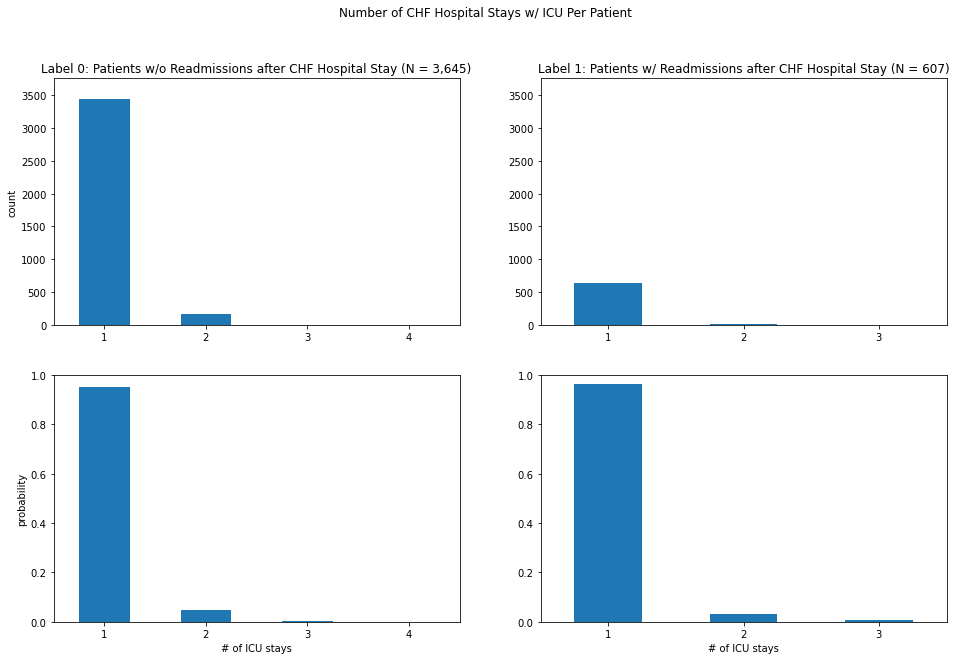

In [205]:
CHF_adm_label_0 = CHF_adm[CHF_adm['labels'] == 0]
CHF_adm_label_1 = CHF_adm[CHF_adm['labels'] == 1]

temp0 = CHF_adm_label_0.groupby('osler_sid')['is_idx_icu'].sum()
temp1 = CHF_adm_label_1.groupby('osler_sid')['is_idx_icu'].sum()

plt.figure(figsize=(16, 10))
plt.subplot(2,2,1)
temp0.value_counts().plot.bar()
plt.xticks(rotation=0, horizontalalignment='center')
plt.title('Label 0: Patients w/o Readmissions after CHF Hospital Stay (N = 3,645)')
plt.ylabel('count')
plt.ylim([0, 3750])

plt.subplot(2,2,2)
temp1.value_counts().plot.bar()
plt.xticks(rotation=0, horizontalalignment='center')
plt.title('Label 1: Patients w/ Readmissions after CHF Hospital Stay (N = 607)')
plt.ylim([0, 3750])
plt.suptitle("Number of CHF Hospital Stays w/ ICU Per Patient")

plt.subplot(2,2,3)
(temp0.value_counts() / temp0.value_counts().sum()).plot.bar()
plt.xticks(rotation=0, horizontalalignment='center')
plt.xlabel('# of ICU stays')
plt.ylabel('probability')
plt.ylim([0, 1])

plt.subplot(2,2,4)
(temp1.value_counts() / temp1.value_counts().sum()).plot.bar()
plt.xticks(rotation=0, horizontalalignment='center')
plt.xlabel('# of ICU stays')
plt.ylim([0, 1])
plt.suptitle("Number of CHF Hospital Stays w/ ICU Per Patient")

plt.show()

### 2. Total time in ICU Per Hospital Stay w/ ICU Stay

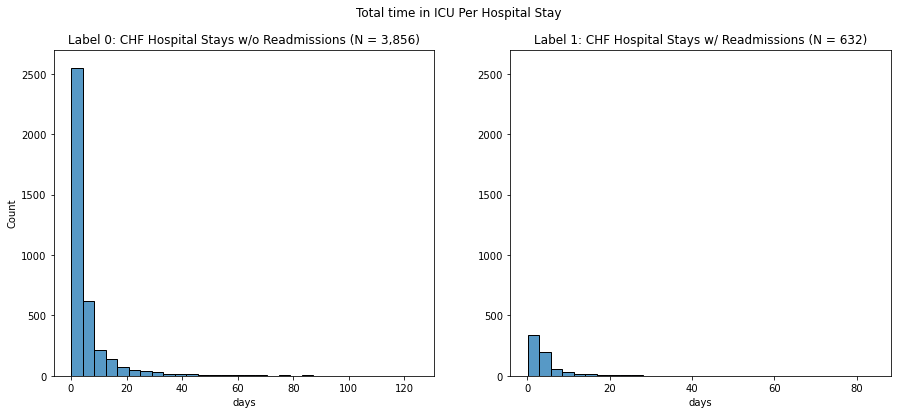

In [206]:
CHF_hosp_icu_stays['ICU_length'] = (CHF_hosp_icu_stays.out_time - CHF_hosp_icu_stays.in_time).dt.total_seconds()/86400

CHF_hosp_icu_stays_label_0 = CHF_hosp_icu_stays[CHF_hosp_icu_stays.labels == 0]
CHF_hosp_icu_stays_label_1 = CHF_hosp_icu_stays[CHF_hosp_icu_stays.labels == 1]

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.histplot(data=CHF_hosp_icu_stays_label_0, x="ICU_length", bins = 30)
plt.title('Label 0: CHF Hospital Stays w/o Readmissions (N = 3,856)')
plt.ylim([0, 2700])
plt.xlabel('days')

plt.subplot(1,2,2)
sns.histplot(data=CHF_hosp_icu_stays_label_1, x="ICU_length", bins = 30)
plt.ylim([0, 2700])
plt.xlabel('days')
plt.ylabel('')
plt.title('Label 1: CHF Hospital Stays w/ Readmissions (N = 632)')

plt.suptitle('Total time in ICU Per Hospital Stay')
plt.show()

### 3. Total time in ICU Per Hospital Stay w/ ICU Stay (Zoomed in)

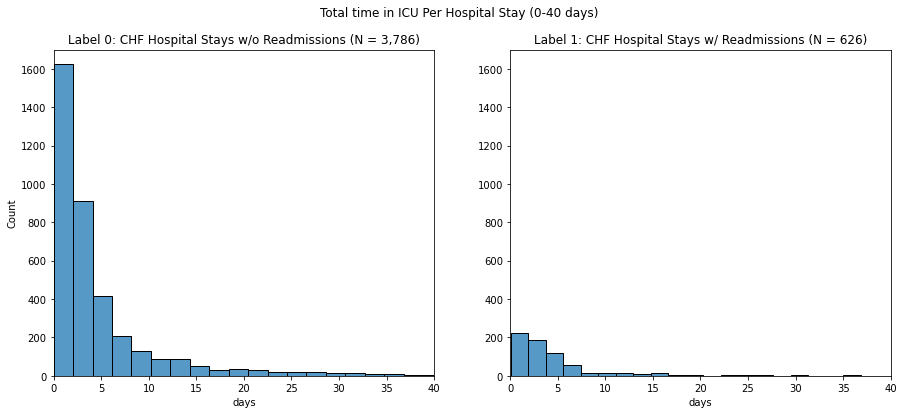

In [207]:
CHF_hosp_icu_stays_label_0_40 = CHF_hosp_icu_stays_label_0[CHF_hosp_icu_stays_label_0.ICU_length < 41]
CHF_hosp_icu_stays_label_1_40 = CHF_hosp_icu_stays_label_1[CHF_hosp_icu_stays_label_1.ICU_length < 41]

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.histplot(data=CHF_hosp_icu_stays_label_0_40, x="ICU_length", bins=20)
plt.title('Label 0: CHF Hospital Stays w/o Readmissions (N = 3,786)')
plt.ylim([0, 1700])
plt.xlim([0, 40])
plt.xlabel('days')

plt.subplot(1,2,2)
sns.histplot(data=CHF_hosp_icu_stays_label_1_40, x="ICU_length", bins=20)
plt.ylim([0, 1700])
plt.xlim([0, 40])
plt.xlabel('days')
plt.ylabel('')
plt.title('Label 1: CHF Hospital Stays w/ Readmissions (N = 626)')

plt.suptitle('Total time in ICU Per Hospital Stay (0-40 days)')
plt.show()

### 4. Days btw CHF Hospital Stay w/ ICU and its Next Readmission

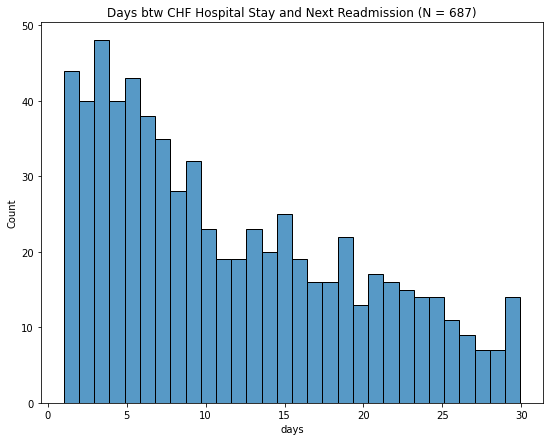

In [208]:
CHF_adm_label_1 = CHF_adm[CHF_adm['labels'] == 1]
plt.figure(figsize = (9, 7))
sns.histplot(data=CHF_adm_label_1, x="time_bt", bins = 30)
plt.title('Days btw CHF Hospital Stay and Next Readmission (N = 687)')
plt.xlabel('days')
plt.show()